In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader


plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style('darkgrid')

In [2]:
dataset = pd.read_csv('/kaggle/input/pimaindiansdiabetes/diabetes.csv')
Y = dataset[['Outcome']]
X = dataset.drop(columns=['Outcome'])

display(Y)
display(X)

# Generate profile report
"""
profile = ProfileReport(dataset)
profile.to_file(output_file='report.html')
"""

FEATURES_LIST = X.columns.values.tolist()

X = X.values
Y = Y.values.ravel()

test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)

,Outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [3]:
def get_unique_adjacent_means(arr):
    # The line below takes mean of every adjacent value
    # example: if the input value is     : [1, 2, 3, 4, 5]
    # the return value of this method is : [1.5, 2.5, 3.5, 4.5]
    return np.convolve(np.unique(arr), [0.5, 0.5], 'valid')

def get_gini_impurity(arr):
    _, counts = np.unique(arr, return_counts=True)
    counts = counts / counts.sum()
    squared_sum = (counts ** 2).sum()
    return 1 - squared_sum

def get_best_criterion(x, y):
    assert(len(x.shape) == 1)
    assert(len(y.shape) == 1)
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    labels = np.unique(y)
    least_gini_impurity = float('inf')
    best_threshold = None
    thresholds = get_unique_adjacent_means(x)
    for threshold in thresholds:
        left = x <= threshold
        right = x > threshold
        y_left, y_right = y[left], y[right]
        y_left_gini_impurity, y_right_gini_impurity = get_gini_impurity(y_left), get_gini_impurity(y_right)
        total_gini_impurity = (len(y_left) * y_left_gini_impurity + len(y_right) * y_right_gini_impurity) / len(y)
        # print(y_left_gini_impurity, y_right_gini_impurity, total_gini_impurity)
        if total_gini_impurity < least_gini_impurity:
            least_gini_impurity = total_gini_impurity
            best_threshold = threshold
    return best_threshold, least_gini_impurity

def get_best_split(X, Y):
    n_cols = len(X[0])
    least_gini_value = float('inf')
    best_col = None
    best_col_threshold = None
    for i in range(n_cols):
        col = X[:, i].ravel()
        threshold, gini_value = get_best_criterion(col, Y)
        # print(f'For column {i}, threshold is {threshold} and gini_value is {gini_value}')
        if gini_value < least_gini_value:
            least_gini_value = gini_value
            best_col = i
            best_col_threshold = threshold
    # print(f'$$$$$$$$ Best split is obtained using col #{best_col} where gini impurity is {least_gini_value} and threshold is {best_col_threshold}')    
    left = X[:, best_col] <= best_col_threshold
    right = ~left
    # print(left)
    X_left, X_right = X[left, :], X[right, :]
    Y_left, Y_right = Y[left], Y[right]
    
    return (X_left, X_right, Y_left, Y_right), (best_col, best_col_threshold)

In [4]:
class DecisionTreeBase():
    def __init__(self, X, Y):
        self._left = None
        self._right = None
        self._is_leaf = None
        self._leaf_label = None
        self._best_col = None
        self._best_threshold = None
        labels_count = np.unique(Y)

        if len(labels_count) == 1:
            self._is_leaf = True
            self._leaf_label = Y[0]
            return

        ((X_left, X_right, Y_left, Y_right), (best_col, best_col_threshold)) = get_best_split(X, Y)
        self._best_col = best_col
        self._best_threshold = best_col_threshold
        self._right = DecisionTreeBase(X_right, Y_right)
        self._left  = DecisionTreeBase(X_left, Y_left)

    def predict(self, x):
        if self._is_leaf:
            return self._leaf_label
        elif x[self._best_col] <= self._best_threshold:
            return self._left.predict(x)
        else:
            return self._right.predict(x)

class DecisionTreeClassifier():
    def __init__(self):
        self._X = None
        self._Y = None

    def fit(self, X, Y):
        self.validate_input(X)
        self._X = X
        self._Y = Y
        self._model = DecisionTreeBase(X, Y)
        
    def predict(self, X):
        self.validate_input(X)
        predictions = []
        for x in X:
            predictions.append(self._model.predict(x))
        return np.array(predictions)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

In [5]:
# Sample dataset for debugging purpose
"""
dataset = np.array([
    [1, 1, 0, 0, 1, 1, 0],
    [1, 0, 1, 1, 1, 0, 0],
    [7, 12, 18, 35, 38, 50, 83]
]).T
labels = np.array([0, 0, 1, 1, 1, 0, 0])

print(dataset)
print(labels)
"""

'\ndataset = np.array([\n    [1, 1, 0, 0, 1, 1, 0],\n    [1, 0, 1, 1, 1, 0, 0],\n    [7, 12, 18, 35, 38, 50, 83]\n]).T\nlabels = np.array([0, 0, 1, 1, 1, 0, 0])\n\nprint(dataset)\nprint(labels)\n'

In [6]:
def traverse_decision_tree(decision_tree):
    print(f'Node info - {decision_tree._best_col} | {decision_tree._best_threshold}')
    if not decision_tree._is_leaf:
        traverse_decision_tree(decision_tree._right)
        traverse_decision_tree(decision_tree._left)

In [7]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.predict(X_test)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,

In [8]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.6818181818181818


In [9]:
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifierSklearn
clf_sklearn = DecisionTreeClassifierSklearn()
clf_sklearn.fit(X_train, y_train)
clf_sklearn.predict(X_test)

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,

In [10]:
print(clf_sklearn.score(X_train, y_train))
print(clf_sklearn.score(X_test, y_test))

1.0
0.6948051948051948


In [11]:
def create_bootstrapped_dataset(X, Y):
    indices = list(range(len(X)))
    chosen_indices = np.random.choice(indices, len(X))
    X_subset = X[chosen_indices]
    Y_subset = Y[chosen_indices]
    oob_indices = list(set(indices) - set(chosen_indices))
    oob_X = X[oob_indices]
    oob_Y = Y[oob_indices]
    return (X_subset, Y_subset), (oob_X, oob_Y)

class RandomForest():
    def __init__(self, n_estimators=10):
        self._n_estimators = n_estimators
        self._dt_clfs = []

    def fit(self, X, Y):
        for i in range(self._n_estimators):
            # Create a bootstrapped dataset
            ((X_subset, Y_subset), _) = create_bootstrapped_dataset(X, Y)
            clf = DecisionTreeClassifier()
            clf.fit(X_subset, Y_subset)
            self._dt_clfs.append(clf)
    
    def predict(self, X):
        predictions = []
        for clf in self._dt_clfs:
            predictions.append(clf.predict(X))
        predictions = np.array(predictions)
        return stats.mode(predictions, axis=0)[0].ravel()
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

For random forest with n_estimators = 1, train accuracy obtained is: 0.8957 and test accuracy obtained is: 0.6851
For random forest with n_estimators = 2, train accuracy obtained is: 0.9000 and test accuracy obtained is: 0.7078
For random forest with n_estimators = 3, train accuracy obtained is: 0.9457 and test accuracy obtained is: 0.6786
For random forest with n_estimators = 4, train accuracy obtained is: 0.9326 and test accuracy obtained is: 0.7305
For random forest with n_estimators = 5, train accuracy obtained is: 0.9565 and test accuracy obtained is: 0.7435
For random forest with n_estimators = 6, train accuracy obtained is: 0.9696 and test accuracy obtained is: 0.7273
For random forest with n_estimators = 7, train accuracy obtained is: 0.9783 and test accuracy obtained is: 0.7565
For random forest with n_estimators = 8, train accuracy obtained is: 0.9783 and test accuracy obtained is: 0.7532
For random forest with n_estimators = 9, train accuracy obtained is: 0.9870 and test acc

,n_estimators,scores
0,1,0.685065
1,2,0.707792
2,3,0.678571
3,4,0.730519
4,5,0.743506
5,6,0.727273
6,7,0.756494
7,8,0.753247
8,9,0.750000
9,10,0.711039


Text(0.5, 1.0, 'Accuracy score vs n_estimators (Random Forest)')

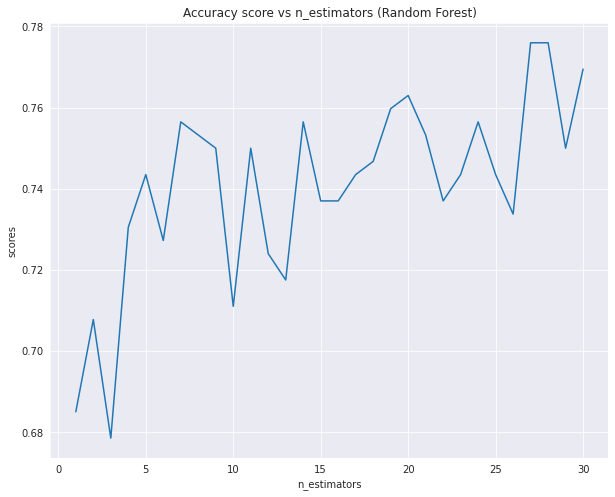

In [12]:
max_n_estimators = 30
scores = []
for n_estimators in range(1, max_n_estimators + 1):
    rfclf = RandomForest(n_estimators=n_estimators)
    rfclf.fit(X_train, y_train)
    train_score = rfclf.score(X_train, y_train)
    score = rfclf.score(X_test, y_test)
    print(f'For random forest with n_estimators = {n_estimators}, train accuracy obtained is: {train_score:.4f} and test accuracy obtained is: {score:.4f}')
    scores.append(score)
df = pd.DataFrame({'n_estimators': list(range(1, max_n_estimators + 1)), 'scores': scores})
display(df)
ax = sns.lineplot(data=df, x='n_estimators', y='scores')
ax.set_title('Accuracy score vs n_estimators (Random Forest)')

For random forest with n_estimators = 1, train accuracy obtained is: 0.8739 and test accuracy obtained is: 0.6753
For random forest with n_estimators = 2, train accuracy obtained is: 0.8957 and test accuracy obtained is: 0.7338
For random forest with n_estimators = 3, train accuracy obtained is: 0.9326 and test accuracy obtained is: 0.6948
For random forest with n_estimators = 4, train accuracy obtained is: 0.9326 and test accuracy obtained is: 0.7143
For random forest with n_estimators = 5, train accuracy obtained is: 0.9783 and test accuracy obtained is: 0.7143
For random forest with n_estimators = 6, train accuracy obtained is: 0.9674 and test accuracy obtained is: 0.7305
For random forest with n_estimators = 7, train accuracy obtained is: 0.9848 and test accuracy obtained is: 0.7370
For random forest with n_estimators = 8, train accuracy obtained is: 0.9848 and test accuracy obtained is: 0.7305
For random forest with n_estimators = 9, train accuracy obtained is: 0.9870 and test acc

,n_estimators,scores
0,1,0.675325
1,2,0.733766
2,3,0.694805
3,4,0.714286
4,5,0.714286
5,6,0.730519
6,7,0.737013
7,8,0.730519
8,9,0.730519
9,10,0.756494


Text(0.5, 1.0, 'Accuracy score vs n_estimators (Random Forest, sklearn)')

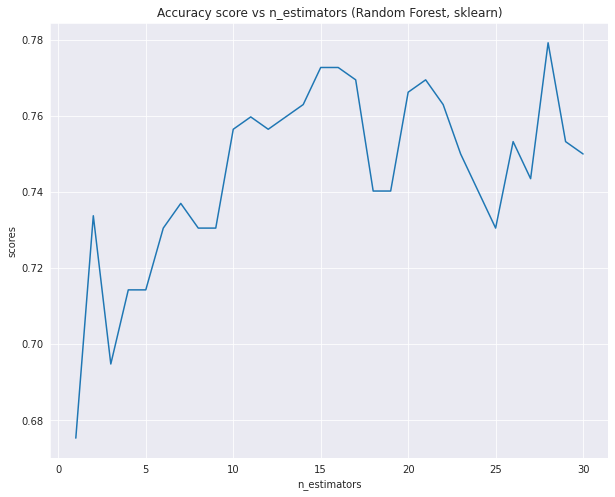

In [13]:
from sklearn.ensemble import RandomForestClassifier

max_n_estimators = 30
scores = []
for n_estimators in range(1, max_n_estimators + 1):
    rfclf = RandomForestClassifier(n_estimators=n_estimators)
    rfclf.fit(X_train, y_train)
    train_score = rfclf.score(X_train, y_train)
    score = rfclf.score(X_test, y_test)
    print(f'For random forest with n_estimators = {n_estimators}, train accuracy obtained is: {train_score:.4f} and test accuracy obtained is: {score:.4f}')
    scores.append(score)
df = pd.DataFrame({'n_estimators': list(range(1, max_n_estimators + 1)), 'scores': scores})
display(df)
ax = sns.lineplot(data=df, x='n_estimators', y='scores')
ax.set_title('Accuracy score vs n_estimators (Random Forest, sklearn)')